In [1]:
import EPUtils
import gdas
from datetime import datetime, timedelta
import numpy as np
import numpy.ma as ma
import scipy.optimize as opt
import matplotlib.pyplot as plt
import random
import copy
import pickle

/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setupto

In [14]:
STATION_STANDARD_DEVIATIONS = {
    'berkeley02': 2.0,
    'berkeley01': 4.0,
    'daejeon01': 0.2,
    'hayward01': 0.1,
    'krakow01': 0.8,
    'lewisburg01': 0.1,
    'mainz01': 0.1,
    'losangeles01': 1.5,
    'moxa01': 1.0,
    'oberlin01': 0.2
}

STATION_SENSITIVE_AXES = { # in form: longitude, long direction?, lattitude, lat direction?, azimuth, altitude
    'beijing01': (116.1868,'E',40.2457,'N',251,0),
    'berkeley02': (122.2570,'W',37.8723,'N',0,90),
    'canberra01': (149.1185,'E',35.2745,'S',0,90),
    'daejeon01': (127.3987,'E',36.3909,'N',0,90),
    'hayward01': (122.0539,'W',37.6564,'N',0,90),
    'krakow01': (19.9048,'E',50.0289,'N',0,90),
    'lewisburg01': (76.8825,'W',40.9557,'N',0,90),
    'losangeles01': (118.4407,'W',34.0705,'N',270,0),
    'mainz01': (8.2354,'E',49.9915,'N',0,-90),
    'moxa01': (11.6147,'E',50.6450,'N',270,0),
    'oberlin01': (82.2204,'W', 41.2950,'N',276,0),
    'belgrade01': (20.3928,'E',44.8546,'N',300,0),
    'test01': (0,'E',0,'N',0,90),
    'test02': (45,'E',30,'N',0,90),
    'test03': (120,'W',45,'N',0,90),
    'test04': (83,'E',20,'N',0,90),
    'test05': (113,'W',45,'S',0,90),
    'test06': (20,'E',17,'S',0,90),
    'test07': (0,'E',90,'N',0,90) # aligned to +z axis
}

# STATION_LIST =['test01','test02','test03','test04','test05','test06'] #'test','test','test','test','test','test','test','test']
# STATION_LIST = ['krakow01','hayward01','lewisburg01', 'mainz01', 'moxa01','daejeon01']
STATION_LIST = ['daejeon01', 'krakow01', 'lewisburg01', 'losangeles01', 'moxa01', 'oberlin01']
BANDWIDTH_LIMIT = 100 #Hz
FREQUENCY_SAMPLING_RATE = 512 #Hz
NUMBER_COINCIDENCE = 4

filepath = "/mnt/d/GNOMEDrive/gnome/serverdata"
start_date = "2020-04-20-08-53-19"
window_length = 2048 # seconds
end_date = EPUtils.get_end_time(start_date, window_length)
min_time_seg_length = 1 # seconds

## END OF USER DEFINED CONSTS ##

cartesian_axes, cartesian_coords = EPUtils.coord_transform(STATION_SENSITIVE_AXES)



In [15]:
xtemp = random.uniform(-1, 1)
ytemp = random.uniform(-1, 1)
ztemp = random.uniform(-1, 1) 
norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]   
i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]
sta_times,data_list, sanity_list, station_arr, starts, ends, stat_obj_list = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE,
                                                                                                filepath=filepath,
                                                                                                shift_time=None,
                                                                                                burst_ampl=3e16,
                                                                                                burst_freq=53,
                                                                                                burst_dur=256,
                                                                                                burst_start=512,
                                                                                                station_axes=cartesian_axes,
                                                                                                station_positions=cartesian_coords,
                                                                                                signal_vec=signal_vector_norm,
                                                                                                velocity=3e5,
                                                                                                impact=0.5,
                                                                                                i_angle=i_angle_offset,
                                                                                                radius=6e7
                                                                                                )



data size mismatch for station daejeon01, padding end
data size mismatch for station krakow01, padding end
data size mismatch for station lewisburg01, padding end
data size mismatch for station losangeles01, padding end
data size mismatch for station moxa01, padding end
data size mismatch for station oberlin01, padding end


In [9]:
for station in stat_obj_list:
    print(station.spec[0][2000:])
    

[1.30650896e-06 6.51530070e-06 2.22415758e-06 2.44948056e-07
 2.50567687e-07 1.47069876e-06 2.21929399e-06 3.17081311e-06
 3.23437475e-06 6.17579755e-07 1.05461437e-06 2.41357592e-06
 2.65798452e-06 5.75094510e-07 1.93949865e-06 3.95382999e-06
 3.20170371e-06 2.65287879e-06 1.04590219e-05 1.23925398e-06
 1.19706270e-06 4.14762674e-07 2.28987259e-06 3.26588168e-06
 1.57285642e-07 2.31384680e-06 7.49702828e-07 2.00198437e-06
 1.95649276e-06 3.06581643e-06 1.84083974e-06 1.91749893e-06
 4.93731314e-07 1.75326509e-06 2.56330625e-07 7.19018375e-07
 1.10617180e-06 1.68959632e-06 8.03496158e-07 1.51539318e-07
            nan            nan            nan            nan
            nan            nan            nan            nan]
[6.01587752e-06 1.45335550e-06 6.37011451e-08 1.01346068e-07
 2.43256857e-06 7.61140881e-07 1.36967450e-06 3.11198415e-07
 2.34192652e-07 1.03225024e-06 6.26805740e-07 1.51151951e-06
 6.72746118e-07 2.28431812e-07 1.04599370e-06 1.23895200e-06
 3.27677318e-06 3.72836

degrees of freedom: 2048.0


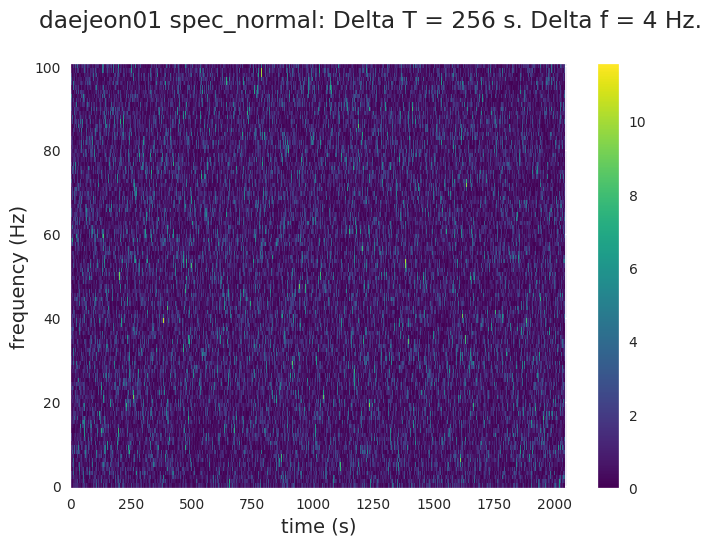

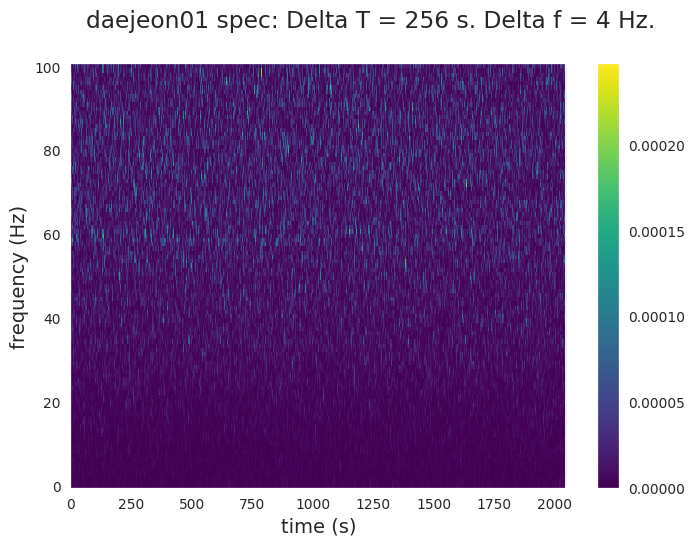

(100, 2048)
degrees of freedom: 2048.0


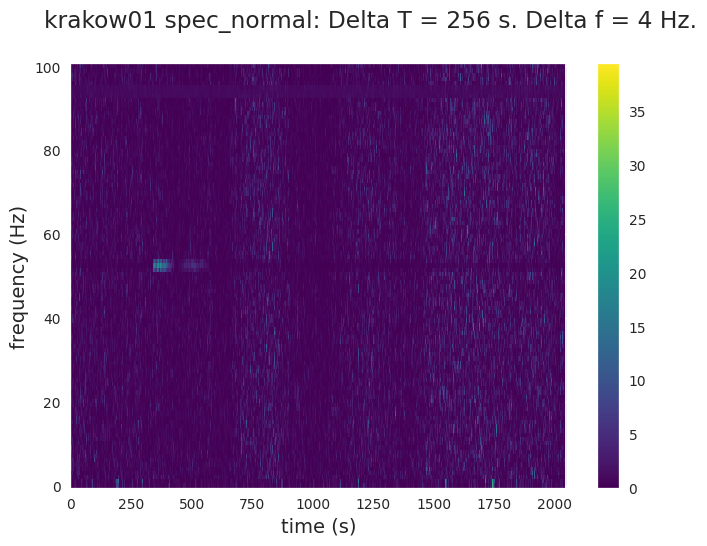

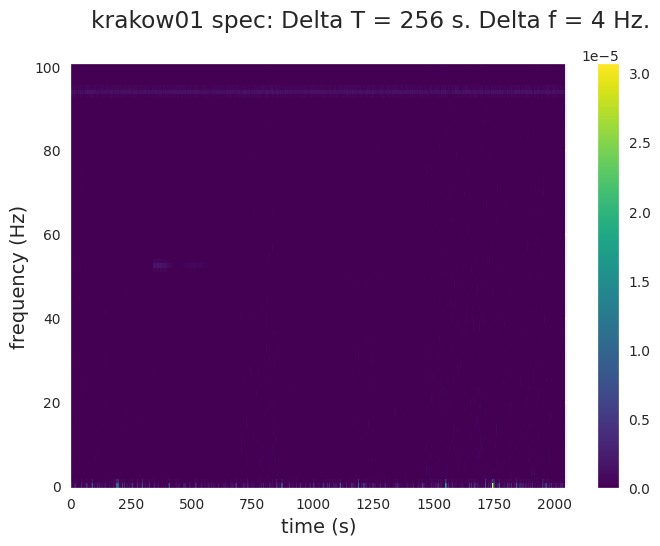

(100, 2048)
degrees of freedom: 2048.0


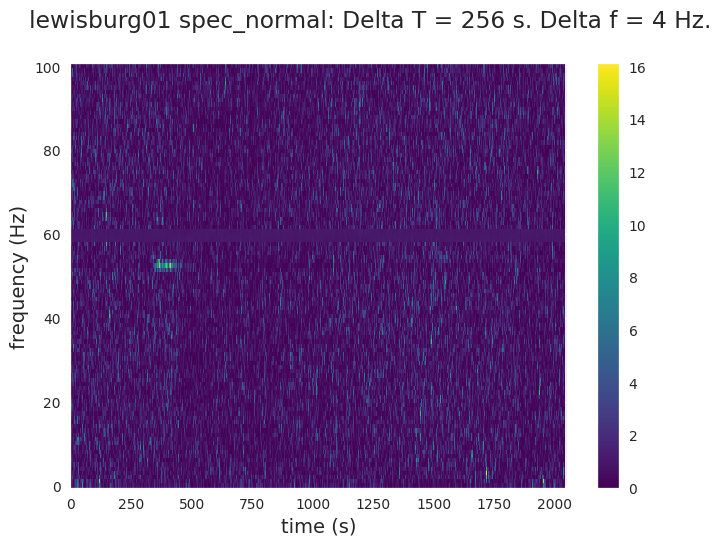

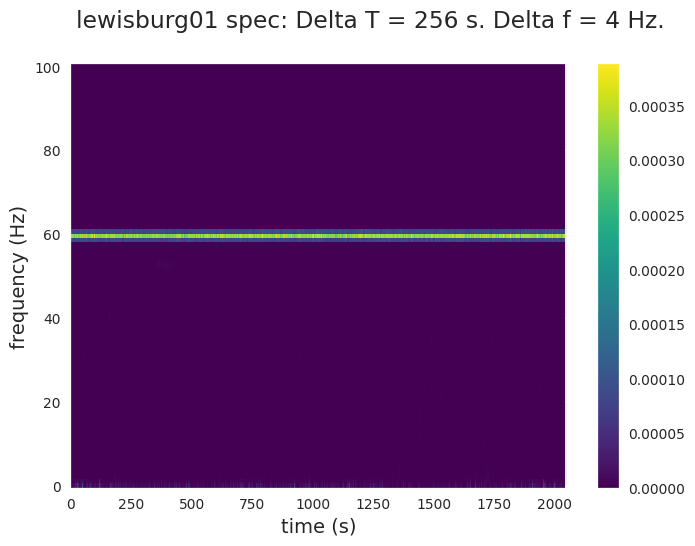

(100, 2048)
degrees of freedom: 2048.0


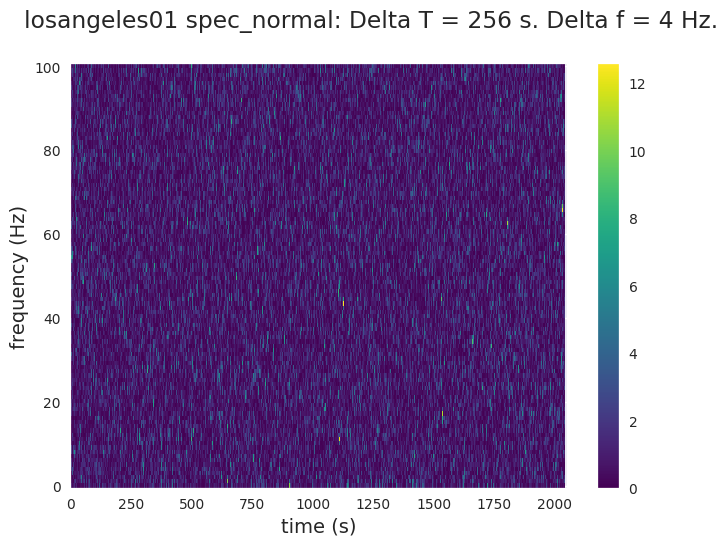

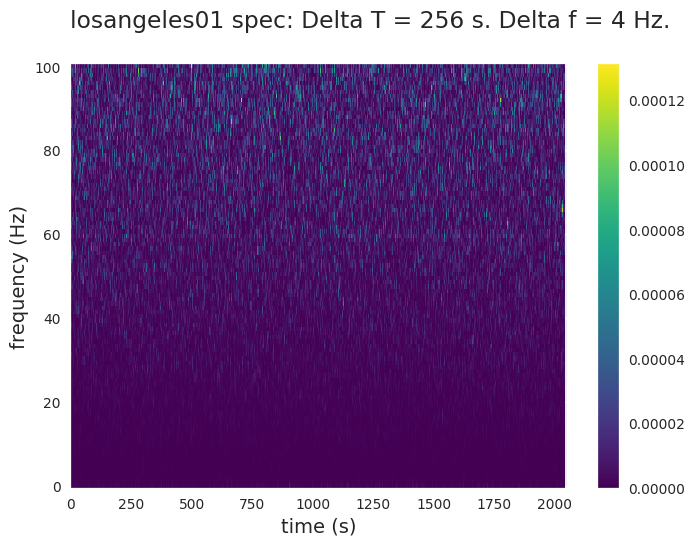

(100, 2048)
degrees of freedom: 2048.0


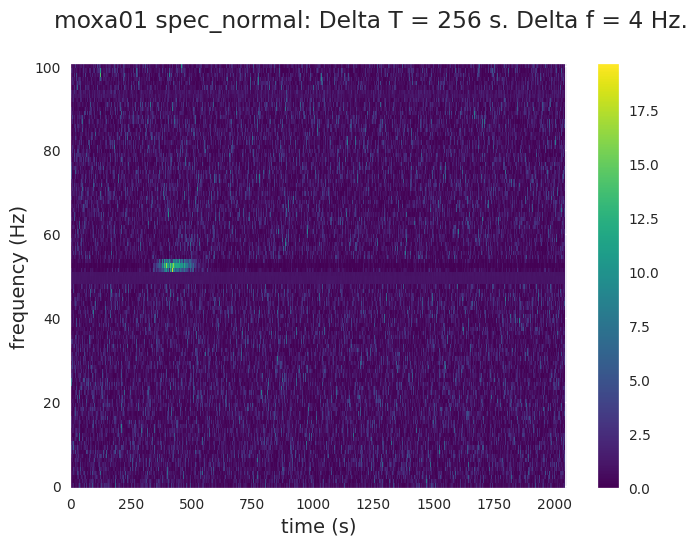

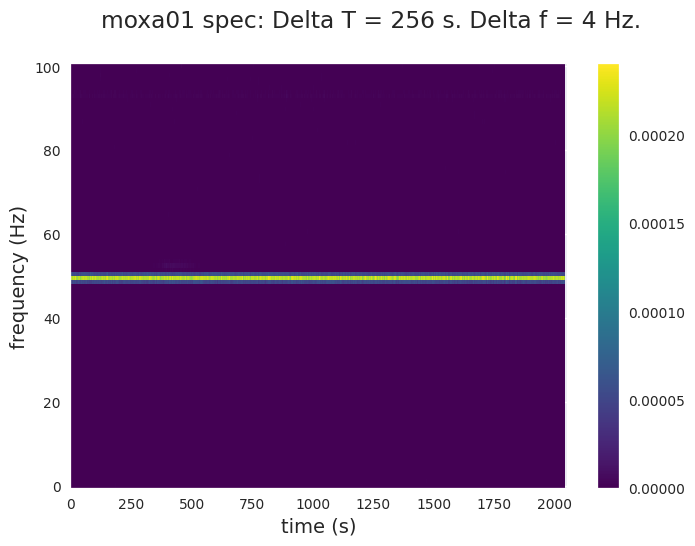

(100, 2048)
degrees of freedom: 2048.0


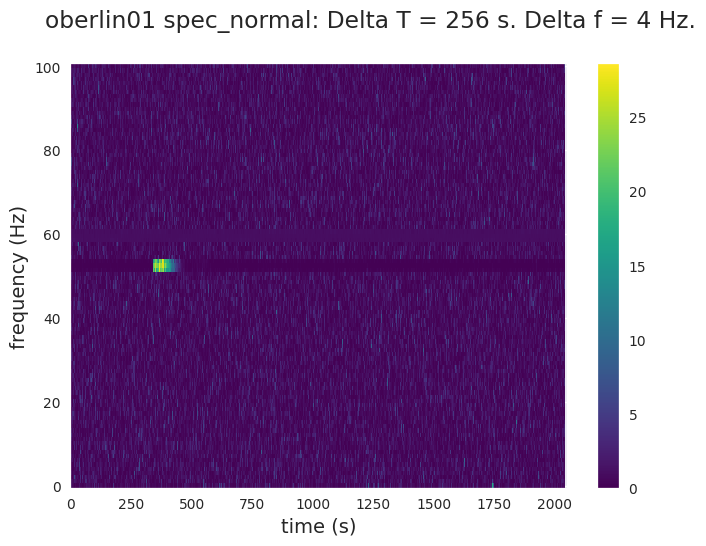

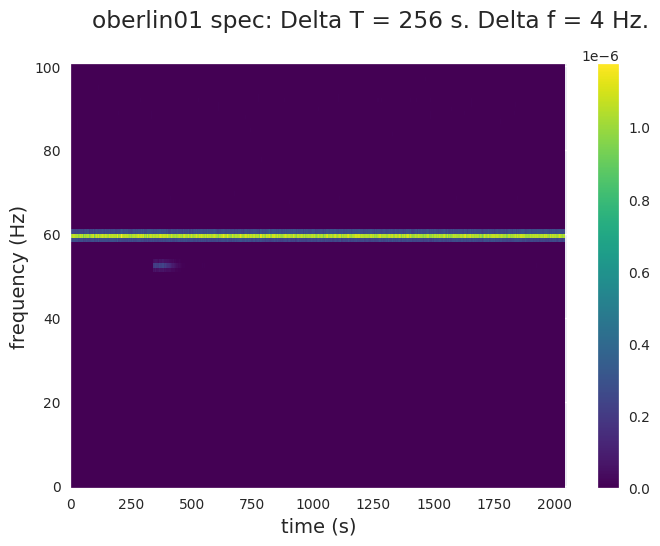

(100, 2048)


In [16]:
for station in stat_obj_list:
    station: EPUtils.Station
    station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
    station.add_tiles(dt=256,df=4,verbose=True,)
    # station.add_tiles(dt=16,df=4,verbose=True)
    
    station.plot_spectrogram('spec_normal')
    station.plot_spectrogram('spec')
    # plt.plot(station.data)
    # plt.show()
    # plt.plot(station.spec_normal)
    # plt.show
    print(station.spec_normal.shape)

In [ ]:
ep_threshold = 130
listofstats = []
for i in np.arange(20,40):
    
    xtemp = random.uniform(-1, 1)
    ytemp = random.uniform(-1, 1)
    ztemp = random.uniform(-1, 1) 
    norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
    
    
    # signal_vector = [burst_amplitude*xtemp/norm_factor, burst_amplitude*ytemp/norm_factor, burst_amplitude*ztemp/norm_factor]
    signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]
    # signal_vector_norm=[1,0,0]
    i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]
    
    ## FOR SPHERICAL COORDINATES ##
    # this should not be used as it does not provide an even distribution of x,y,z coordinate points
    
    # phi = random.random()*np.pi
    # theta = random.random()*np.pi*2
    # signal_vector = [burst_amplitude*np.sin(phi)*np.cos(theta),burst_amplitude*np.sin(phi)*np.sin(theta),burst_amplitude*np.cos(phi)]
    # signal_vector_norm = [np.sin(phi)*np.cos(theta),np.sin(phi)*np.sin(theta),np.cos(phi)]

    cartesian_axes, cartesian_coords = EPUtils.coord_transform(STATION_SENSITIVE_AXES)
    
    sta_times,data_list, sanity_list, station_arr, starts, ends, stat_obj_list = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE,
                                                                                                filepath=filepath,
                                                                                                shift_time=None,
                                                                                                # burst_ampl=5e18,
                                                                                                burst_ampl=3e19,
                                                                                                burst_freq=53,
                                                                                                burst_dur=256,
                                                                                                burst_start=512,
                                                                                                station_axes=cartesian_axes,
                                                                                                station_positions=cartesian_coords,
                                                                                                signal_vec=signal_vector_norm,
                                                                                                velocity=3e5,
                                                                                                impact=0.5,
                                                                                                i_angle=i_angle_offset,
                                                                                                radius=6e7
                                                                                                )

    for station in stat_obj_list:
        station: EPUtils.Station
        station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=True)
    
    stat_obj_list.append(signal_vector_norm)
    stat_obj_list.append(i_angle_offset)
    # with open(filepath+'7-17-50-stations/injection-{}.pkl'.format(i),'wb') as f:
    # with open(filepath+'7-29-50-stations/injection-{}.pkl'.format(i),'wb') as f:
    #     pickle.dump(stat_obj_list,f, protocol=pickle.HIGHEST_PROTOCOL)
    

    
    
    

In [ ]:
# load data and calculate m
with open(filepath+'7-17-50-stations/injection-19.pkl','rb') as f:
        data = pickle.load(f)
        offset_directions = data.pop()
        signal_vector = data.pop()
        stat_obj_list = data

for station in stat_obj_list:
        station: EPUtils.Station
        station.add_tiles(dt=16,df=4,verbose=True)
        # station.add_tiles(dt=256,df=4,verbose=True)
        
stat_obj_list[3].plot_spectrogram("spec_summed",show_ts = True)
stat_obj_list[3].plot_spectrogram("spec_normal_summed",show_ts = True)
stat_obj_list[5].plot_spectrogram("spec_normal_summed",show_ts = True)
stat_obj_list[2].plot_spectrogram("spec_normal_summed",show_ts = True)
stat_obj_list[3].plot_spectrogram("spec_normal_summed",show_ts = True)

for station in stat_obj_list:
        plt.plot(station.spec_normal_summed[13],)
plt.show()
coin_mask = np.zeros(stat_obj_list[0].spec_summed.shape)
# coin_mask[13][23:35] =1
coin_mask[13] =1
fp_frac, mask = EPUtils.mask(160,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=True)

stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency(stat_obj_list,mask,cartesian_axes,140,signal_vector,verbose=True,consistency_mask=coin_mask)

plt.plot(mlist)
fig, ax = plt.subplots()
ax = fig.add_subplot(projection='3d')
coordlist = np.transpose(mlist)
ax.scatter(coordlist[0],coordlist[1],coordlist[2])
ax.scatter([signal_vector[0]],[signal_vector[1]],[signal_vector[2]])
ax.scatter([0],[0],[0])
print(signal_vector)

parsed = ''
for i in range(coordlist[0].size):
        parsed = parsed + ",({},{},{})".format(coordlist[0][i],coordlist[1][i],coordlist[2][i])

print(parsed)


# veclst.extend(passed_events)
# print(passed_events)
# x2.extend(x2list)
# ms.append(np.array(mlist))
# print('{}: {}'.format(i,s))


In [ ]:
signals = np.linspace(.01,0.25,20)
signals = np.append(signals, np.linspace(.3,.5,5))
print(signals)
mins = []
maxs = []
means = []

alldata = []
mlists = []

tilesum = []
station_objects = []

# for s in signals:
for s in np.array([0,.1,.5]):
# for s in np.array([0,.1,.3,.5,5,10,20]):

    burst_amplitude = 2
    ep_threshold = 130
    veclst = []
    x2 = []
    ms =[]
    for i in range(50):
        
        xtemp = random.uniform(-1, 1)
        ytemp = random.uniform(-1, 1)
        ztemp = random.uniform(-1, 1) 
        norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
        signal_vector = [burst_amplitude*xtemp/norm_factor, burst_amplitude*ytemp/norm_factor, burst_amplitude*ztemp/norm_factor]
        signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]
        # signal_vector_norm=[1,0,0]
        i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]
        
        ## FOR SPHERICAL COORDINATES ##
        # this should not be used as it does not provide an even distribution of x,y,z coordinate points
        
        # phi = random.random()*np.pi
        # theta = random.random()*np.pi*2
        # signal_vector = [burst_amplitude*np.sin(phi)*np.cos(theta),burst_amplitude*np.sin(phi)*np.sin(theta),burst_amplitude*np.cos(phi)]
        # signal_vector_norm = [np.sin(phi)*np.cos(theta),np.sin(phi)*np.sin(theta),np.cos(phi)]

        cartesian_axes, cartesian_coords = EPUtils.coord_transform(STATION_SENSITIVE_AXES)
        
        sta_times,data_list, sanity_list, station_arr, starts, ends, stat_obj_list = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE,
                                                                                                    filepath=filepath,
                                                                                                    shift_time=None,
                                                                                                    # burst_ampl=5e18,
                                                                                                    burst_ampl=5e20,
                                                                                                    burst_freq=53,
                                                                                                    burst_dur=256,
                                                                                                    burst_start=512,
                                                                                                    station_axes=cartesian_axes,
                                                                                                    station_positions=cartesian_coords,
                                                                                                    signal_vec=signal_vector_norm,
                                                                                                    velocity=3e5,
                                                                                                    impact=0.5,
                                                                                                    i_angle=i_angle_offset,
                                                                                                    radius=6e7
                                                                                                    )

        for station in stat_obj_list:
            station: EPUtils.Station
            station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=True)
            # station.plot_spectrogram('spec')
            
            
            
            # for i in np.array([2,4,8,16,32,64,128,256,512]):
            station.add_tiles(dt=16,df=4,verbose=False)
                
            #     station.plot_spectrogram('spec_normal_summed')
            #     tilesum.append(station.spec_normal_summed[24][0])                
            # fig, ax = plt.subplots()
            # ax.plot(tilesum)
            # ax.set_yscale('log')
            # plt.show()
                
            # itm = station.spec_normal_summed.ravel()
            # print(itm)
            # plt.hist(2*station.spec_normal_summed.ravel()[8:],50)
            # plt.hist(2*station.spec_normal_summed.ravel()[:8],10)
            
            # plt.show()
            # print('mean excess power: {}'.format(np.mean(station.spec_normal_summed)*2))
            # print('mean excess power for calc spec: {}'.format(np.mean(station.calc)*2))
            # station.plot_spectrogram('spec_normal')
            # station.plot_spectrogram('calc')
            # print(np.mean(station.spec_normal))
        # break
        coin_mask = np.zeros(stat_obj_list[0].spec_summed.shape)
        # coin_mask[49][:8] =1
        fp_frac, mask = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=False)
        # plt.plot(fp_frac)
        # plt.show()
        # stat_obj_list[0].plot_spectrogram()
        # break
        stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency(stat_obj_list,mask,cartesian_axes,ep_threshold,signal_vector,verbose=True,consistency_mask=coin_mask)
        veclst.extend(passed_events)
        print(passed_events)
        x2.extend(x2list)
        ms.append(np.array(mlist))
        print('{}: {}'.format(i,s))
        # alldata.append([stat,xind,yind,mlist,x2list,passed_events])
        # for station in stat_obj_list:
        #     plt.plot(station.subtracted[49])
        # stat_obj_list[0].plot_spectrogram('spec_normal_summed')
        # plt.imshow(coin_mask,'viridis')
    # plt.hist(veclst,50)
    # plt.show()
    veclst = np.array(veclst)
    alldata.append(veclst[~np.isnan(veclst)])
    mean = np.mean(veclst[~np.isnan(veclst)])
    means.append(mean)
    try:
        mins.append(mean - np.percentile(veclst[~np.isnan(veclst)],10))
        maxs.append(np.percentile(veclst[~np.isnan(veclst)],90)-mean)
    except:
        mins.append(0)
        maxs.append(0)
    # with open(filepath+'ep130LargeSetCheckpoint_{}.pkl'.format(s),'wb') as f:
    #     pickle.dump(alldata,f)
    print(s)
    
    mlists.append(ms)
    
    

# plt.errorbar(means,signals,None,np.array([mins,maxs]))



# with open(filepath+'ep130LargeSet.pkl','wb') as f:
#     pickle.dump(alldata,f)



# # print(stat)
# # print(xind)
# # print(mlist)
# plt.hist(veclst,50)
# # plt.hist(x2,50)
# print(np.mean(veclst))



In [ ]:
# mns = []
# min =[]
# max=[]
# import pickle
# with open(filepath+'ep170.pkl','rb') as f:
#     alldata = pickle.load(f)

# for i, list in enumerate(alldata):
#     list = np.array(list)
#     list2nd = list[~np.isnan(list)]
#     mns.append(np.mean(list[~np.isnan(list)]))
#     min.append(np.percentile(list[~np.isnan(list)],10))
#     max.append(np.percentile(list[~np.isnan(list)],90))
#     # plt.hist(list[~np.isnan(list)],50)
# plt.errorbar(mns,signals,None,np.array([min,max]))
# print("\nData type:", np.array(alldata[1]).dtype)
# print("Contains NaN:", np.isnan(alldata[1]).any())
# print("Contains inf:", np.isinf(alldata[1]).any())

In [ ]:

# load in data
axes_directions = []
offset_directions = []
station_data = []


for i in range(50):
    with open(filepath+'7-17-50-stations/injection-{}.pkl'.format(i),'rb') as f:
        data = pickle.load(f)
        offset_directions.append(data.pop())
        axes_directions.append(data.pop())
        station_data.append(data)
        print(i)
        

        for station in stat_obj_list:
            station: EPUtils.Station
            station.add_tiles(dt=16,df=4,verbose=False)
                

        coin_mask = np.zeros(stat_obj_list[0].spec_summed.shape)
        coin_mask[11][23:35] =1
        fp_frac, mask = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=False)

        stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency(stat_obj_list,mask,cartesian_axes,ep_threshold,signal_vector,verbose=True,consistency_mask=coin_mask)
        veclst.extend(passed_events)
        print(passed_events)
        x2.extend(x2list)
        ms.append(np.array(mlist))
        print('{}: {}'.format(i,s))

    veclst = np.array(veclst)
    alldata.append(veclst[~np.isnan(veclst)])
    mean = np.mean(veclst[~np.isnan(veclst)])
    means.append(mean)
    try:
        mins.append(mean - np.percentile(veclst[~np.isnan(veclst)],10))
        maxs.append(np.percentile(veclst[~np.isnan(veclst)],90)-mean)
    except:
        mins.append(0)
        maxs.append(0)

    print(s)
    
    mlists.append(ms)



In [ ]:
min = []
max = []

for data in alldata:
    mean = np.mean(data[~np.isnan(data)])
    min.append(mean - np.percentile(data[~np.isnan(data)],10))
    max.append(np.percentile(data[~np.isnan(data)],90) - mean)
    
plt.errorbar(means,signals,None,np.array([min,max]))

In [ ]:
list = np.array(alldata[0])
list = list[~np.isnan(list)]
mean = np.mean(list)
sorted = np.sort(list)
stdlist =[]
for i in np.linspace(0,sorted.__len__()//2-1,70):
    stdlist.append(np.std(sorted[int(i):]))

plt.plot(np.gradient(stdlist))
# plt.plot(stdlist)
sorted
# plt.hist(sorted,50)

In [ ]:
import pickle

# with open(filepath+'130epRevisedCoordinateGen.pkl'.format(1.2),'wb') as f:
#     pickle.dump(alldata,f)


In [ ]:
plt.hist(alldata[2],90)
# alldata[0]
# alldata


In [ ]:
df = 2
dt= 2
arr = np.arange(100).reshape((10,10))
print(arr)
x=np.size(arr,0)
y=np.size(arr,1)
sum = arr.reshape(x//dt,dt,y//df,df).transpose(0,2,1,3).reshape(-1,df*dt).sum(axis=1)
shape = np.reshape(sum,(x//dt,y//df))
np.repeat(np.repeat(shape,df,axis=0),dt,axis=1)

In [ ]:
matrix = np.arange(16).reshape(4,4)
dx = 2
dy =2

m, n = matrix.shape

# Ensure the dimensions are divisible by dy and dx
if m % dy != 0 or n % dx != 0:
    raise ValueError("Matrix dimensions must be divisible by tile dimensions.")

# Reshape into blocks and sum
reshaped = matrix.reshape(m // dy, dy, n // dx, dx)
summed = reshaped.sum(axis=(1, 3)) 
stretched = np.kron(summed, np.ones((dy, dx))).astype(int)
stretched


In [ ]:
m_list = mlists[0]

print(mlists[0])

# np.ravel(m_list)
plt.hist(np.sqrt(np.sum(np.square(np.vstack(m_list)),axis=1)),50)

# np.sum(np.array(m_list)**2,axis=1)


# plt.hist(np.hstack(ms)/.1,50)

In [ ]:
x=np.linspace(0,19, 20)
y=np.linspace(0,9,10)
xarr, yarr = np.meshgrid(x,y)
np.vstack([xarr.ravel(), yarr.ravel()]).reshape(20,20)

In [ ]:
xlen = 5
ylen = 5
y,x=np.meshgrid(np.arange(ylen),np.arange(xlen), indexing='ij')
# arr = np.stack((y,x),axis=-1)
x
# arr[3,4]
ma.array(y,mask=x)

In [ ]:
(x.all(1).__invert__()*x.T).T.std(1)

In [ ]:
np.sqrt(np.sum(np.arange(21).reshape(7,3)**2,axis=1))

In [ ]:
mask1 = ma.array(np.arange(5),mask=[1,1,1,0,0])
mask2 = ma.array(np.arange(5),mask=[0,0,1,1,1])

mask1.__setmask__(mask1.mask & mask2.mask)
mask1.mask

In [ ]:
print('test'.format(1.2))